In [1]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.9 MB/s eta 0:00:00


In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

In [3]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

In [22]:
# Modelado y Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster
from skforecast.metrics import calculate_coverage
from skforecast.plot import plot_prediction_intervals
import shap
import math

In [5]:
from google.colab import files

uploaded = files.upload()

Saving 001_ZW Parque Ingenio-1AP.csv to 001_ZW Parque Ingenio-1AP.csv


In [48]:
import io

#df = pd.read_csv(io.BytesIO(uploaded['001_ZW Parque Ingenio-1AP.csv']))
df = pd.read_csv(io.BytesIO(uploaded['001_ZW Parque Ingenio-1AP.csv']), decimal=",")
print(df)

    FECHA.CONEXION  DIA_SEMANA  LABORAL  FIN_DE_SEMANA  FESTIVO  \
0       2024-01-01           0        0              0        1   
1       2024-01-02           1        1              0        0   
2       2024-01-03           2        1              0        0   
3       2024-01-04           3        1              0        0   
4       2024-01-05           4        1              0        0   
..             ...         ...      ...            ...      ...   
451     2025-03-27           3        1              0        0   
452     2025-03-28           4        1              0        0   
453     2025-03-29           5        0              1        0   
454     2025-03-30           6        0              1        0   
455     2025-03-31           0        1              0        0   

     PORCENTAJE.USO  NUMERO.CONEXIONES  USAGE.KB  
0             424.4                 42   3709424  
1             140.3                 21   1181558  
2             168.1                 34   2

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [49]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.18.0
Versión scikit-learn: 1.6.1
Versión pandas: 2.2.2
Versión numpy: 2.0.2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [50]:
# Preparación del dato
# ==============================================================================
df['FECHA.CONEXION'] = pd.to_datetime(df['FECHA.CONEXION'], format='%Y-%m-%d')
df = df.set_index('FECHA.CONEXION')
df = df.asfreq('D') # Month Start (04-01; 05-01; 06-01...)
df

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,DIA_SEMANA,LABORAL,FIN_DE_SEMANA,FESTIVO,PORCENTAJE.USO,NUMERO.CONEXIONES,USAGE.KB
FECHA.CONEXION,,,,,,,
2024-01-01,0,0,0,1,424.4,42,3709424
2024-01-02,1,1,0,0,140.3,21,1181558
2024-01-03,2,1,0,0,168.1,34,2036539
2024-01-04,3,1,0,0,135.1,31,1427081
2024-01-05,4,1,0,0,193.5,35,2097912
...,...,...,...,...,...,...,...
2025-03-27,3,1,0,0,42.0,35,1535923
2025-03-28,4,1,0,0,104.0,25,2514551
2025-03-29,5,0,1,0,242.0,53,7752711


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [51]:
df = df.sort_index() # En caso de que esten las fechas desorganizadas se organizan de forma ascendente
df

,DIA_SEMANA,LABORAL,FIN_DE_SEMANA,FESTIVO,PORCENTAJE.USO,NUMERO.CONEXIONES,USAGE.KB
FECHA.CONEXION,,,,,,,
2024-01-01,0,0,0,1,424.4,42,3709424
2024-01-02,1,1,0,0,140.3,21,1181558
2024-01-03,2,1,0,0,168.1,34,2036539
2024-01-04,3,1,0,0,135.1,31,1427081
2024-01-05,4,1,0,0,193.5,35,2097912
...,...,...,...,...,...,...,...
2025-03-27,3,1,0,0,42.0,35,1535923
2025-03-28,4,1,0,0,104.0,25,2514551
2025-03-29,5,0,1,0,242.0,53,7752711


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [52]:
#df["USAGE_LOG"] = np.log1p(df["USAGE.KB"])
#df["PORCENTAJE_LOG"] = np.log1p(df["PORCENTAJE.USO"])
#df["CONEXIONES_LOG"] = np.log1p(df["NUMERO.CONEXIONES"])

In [53]:
df

,DIA_SEMANA,LABORAL,FIN_DE_SEMANA,FESTIVO,PORCENTAJE.USO,NUMERO.CONEXIONES,USAGE.KB
FECHA.CONEXION,,,,,,,
2024-01-01,0,0,0,1,424.4,42,3709424
2024-01-02,1,1,0,0,140.3,21,1181558
2024-01-03,2,1,0,0,168.1,34,2036539
2024-01-04,3,1,0,0,135.1,31,1427081
2024-01-05,4,1,0,0,193.5,35,2097912
...,...,...,...,...,...,...,...
2025-03-27,3,1,0,0,42.0,35,1535923
2025-03-28,4,1,0,0,104.0,25,2514551
2025-03-29,5,0,1,0,242.0,53,7752711


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


En caso de que se tenga que convertir la columna PORCENTAJE.USO:

In [54]:
df.dtypes

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,0
DIA_SEMANA,int64
LABORAL,int64
FIN_DE_SEMANA,int64
FESTIVO,int64
PORCENTAJE.USO,float64
NUMERO.CONEXIONES,int64
USAGE.KB,int64


In [55]:
#df['NUMERO.CONEXIONES'].str.replace(',', '.', regex=True)

In [56]:
print(f'Número de filas con missing values: {df.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [57]:
rows_with_na = df[df.isna().any(axis=1)]
print("\nRows with any NA values:")
print(rows_with_na)


Rows with any NA values:
Empty DataFrame
Columns: [DIA_SEMANA, LABORAL, FIN_DE_SEMANA, FESTIVO, PORCENTAJE.USO, NUMERO.CONEXIONES, USAGE.KB]
Index: []


In [58]:
rows, columns = df.shape
rows

456

Steps, el número en que se va a separar el datset en train y test

In [61]:
steps = rows*0.1
steps = math.floor(steps)
steps

45

In [62]:
# Separación datos train-test
# ==============================================================================
df_train = df[:-steps]
df_test  = df[-steps:]
print(f"Fechas train : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Fechas test  : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Fechas train : 2024-01-01 00:00:00 --- 2025-02-14 00:00:00  (n=411)
Fechas test  : 2025-02-15 00:00:00 --- 2025-03-31 00:00:00  (n=45)


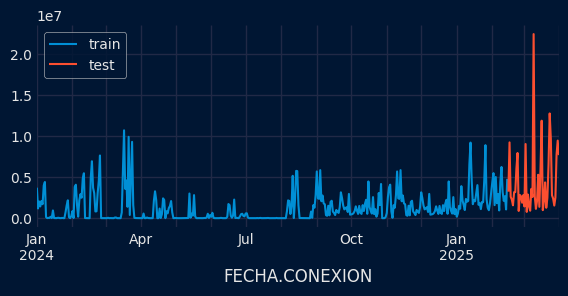

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [63]:
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
ax.legend();

In [64]:
# Create and train forecaster WITH exogenous variables
# Keep using ForecasterRecursive as in your original code
forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=123),
    lags=6
)
# Ajuste con variables exogenas
forecaster.fit(
    y=df_train['USAGE.KB'],
    exog=df_train[['PORCENTAJE.USO', 'NUMERO.CONEXIONES']]  # Add exogenous variables here
)

# Ajuste sin variables exogenas
#forecaster.fit(
#    y=df_train['USAGE.KB']
#)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [69]:
# Predicciones con variables exogenas futuras
predictions = forecaster.predict(
    steps=steps,
    exog=df_test[['PORCENTAJE.USO', 'NUMERO.CONEXIONES']]  # Future values of exogenous variables
)

# Predicciones sin variables exogenas futuras
#predictions = forecaster.predict(
#    steps=steps
#)
#predictions.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


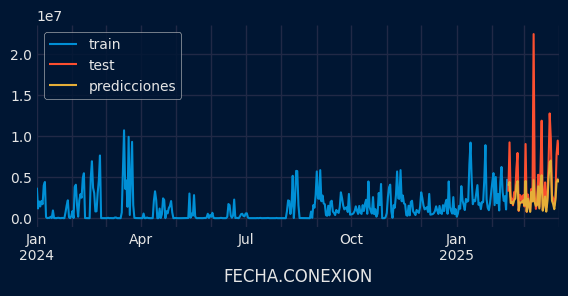

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [70]:
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predicciones')
ax.legend();

In [67]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_test['USAGE.KB'],
                y_pred = predictions
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 11665675869633.893


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
predictions_normal = np.expm1(predictions)
predictions_normal.head()

,pred
2024-12-31,1.567828e+06
2025-01-01,7.842455e+05
2025-01-02,1.711120e+06
2025-01-03,5.797501e+06
2025-01-04,2.153644e+06


In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_test['USAGE.KB'],
                y_pred = predictions_normal
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 17463539780757.912


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


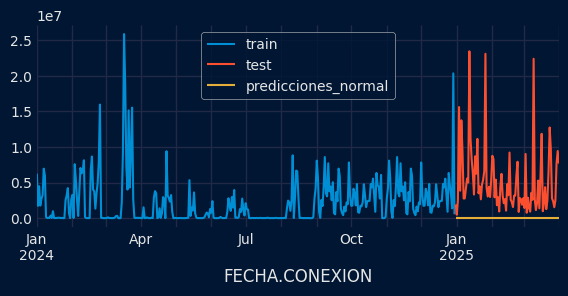

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Gráfico de predicciones normales (sin logaritmo) vs valores reales (sin logaritmo)
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
df_train['USAGE.KB'].plot(ax=ax, label='train')
df_test['USAGE.KB'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predicciones_normal')
ax.legend();

In [ ]:
# hyperparameters search: grid search with exogenous variables
forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# train and validation partitions
cv = TimeSeriesFold(
      steps              = 91,
      initial_train_size = int(len(df_train) * 0.5),
      refit              = False,
      fixed_train_size   = False,
    )

# candidate values of lags
lags_grid = [10, 20]

# Candidate values of hyperparameters of the regressor
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = df_train['USAGE_LOG'],
                        exog        = df_train[['PORCENTAJE_LOG', 'CONEXIONES_LOG']],  # ADDED: Include exogenous variables
                        cv          = cv,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        metric      = 'mean_squared_error',
                        return_best = True,
                        n_jobs      = 'auto',
                        verbose     = False
                  )

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.874542426349119


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Resultados de la búsqueda de hiperparámetros
# ==============================================================================
resultados_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",0.874542,3,250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.885926,3,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.892568,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.907353,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",0.908474,3,250
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 250}",0.909963,5,250
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.910173,5,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 250}",0.921170,5,250
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 250}",0.930477,10,250
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 250}",0.930835,10,250


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
